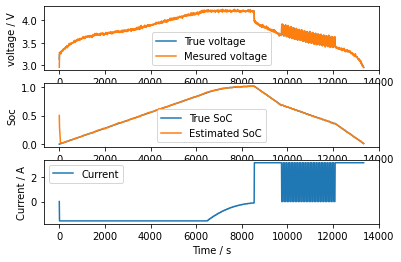

In [8]:
from battery import Battery
from kalman import ExtendedKalmanFilter as EKF
from protocol import launch_experiment_protocol
import numpy as np
import math as m

import matplotlib.pyplot as plt 
from datetime import datetime  
import pandas as pd 
 
 

def get_EKF(R0, R1, C1, std_dev, time_step):
    # initial state (SoC is intentionally set to a wrong value)
    # x = [[SoC], [RC voltage]]
    x = np.matrix([[0.5],\
                   [0.0]])

    exp_coeff = m.exp(-time_step/(C1*R1))
    
    # state transition model
    F = np.matrix([[1, 0        ],\
                   [0, exp_coeff]])

    # control-input model
    B = np.matrix([[-time_step/(Q_tot * 3600)],\
                   [ R1*(1-exp_coeff)]])

    # variance from std_dev
    var = std_dev ** 2

    # measurement noise
    R = var

    # state covariance
    P = np.matrix([[var, 0],\
                   [0, var]])

    # process noise covariance matrix
    Q = np.matrix([[var/50, 0],\
                   [0, var/50]])

    def HJacobian(x):
        return np.matrix([[battery_simulation.OCV_model.deriv(x[0,0]), -1]])

    def Hx(x):
        return battery_simulation.OCV_model(x[0,0]) - x[1,0]

    return EKF(x, F, B, P, Q, R, Hx, HJacobian)


def plot_everything(time, true_voltage, mes_voltage, true_SoC, estim_SoC, current):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    # title, labels
    ax1.set_title('')    
    ax1.set_xlabel('Time / s')
    ax1.set_ylabel('voltage / V')
    ax2.set_xlabel('Time / s')
    ax2.set_ylabel('Soc')
    ax3.set_xlabel('Time / s')
    ax3.set_ylabel('Current / A')


    ax1.plot(time, true_voltage, label="True voltage")
    ax1.plot(time, mes_voltage, label="Mesured voltage")
    ax2.plot(time, true_SoC, label="True SoC")
    ax2.plot(time, estim_SoC, label="Estimated SoC")
    ax3.plot(time, current, label="Current")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()


if __name__ == '__main__':
    # total capacity
    Q_tot = 3.2
    
    # Thevenin model values
    R0 = 0.062
    R1 = 0.01
    C1 = 3000
    
    # time period
    time_step = 10

    battery_simulation = Battery(Q_tot, R0, R1, C1)

    # discharged battery
    battery_simulation.actual_capacity = 0
    
    # measurement noise standard deviation
    std_dev = 0.015

    #get configured EKF
    Kf = get_EKF(R0, R1, C1, std_dev, time_step)

    time         = [0]
    true_SoC     = [battery_simulation.state_of_charge]
    estim_SoC    = [Kf.x[0,0]]
    true_voltage = [battery_simulation.voltage]
    mes_voltage  = [battery_simulation.voltage + np.random.normal(0,0.1,1)[0]]
    current      = [battery_simulation.current]

    def update_all(actual_current):
        battery_simulation.current = actual_current
        battery_simulation.update(time_step)

        time.append(time[-1]+time_step)
        current.append(actual_current)

        true_voltage.append(battery_simulation.voltage)
        mes_voltage.append(battery_simulation.voltage + np.random.normal(0, std_dev, 1)[0])
        
        Kf.predict(u=actual_current)
        Kf.update(mes_voltage[-1] + R0 * actual_current)
        
        true_SoC.append(battery_simulation.state_of_charge)
        estim_SoC.append(Kf.x[0,0])
        
        return battery_simulation.voltage #mes_voltage[-1]
    
    # launch experiment
    launch_experiment_protocol(Q_tot, time_step, update_all)

    # plot stuff
    plot_everything(time, true_voltage, mes_voltage, true_SoC, estim_SoC, current)


In [35]:
from battery import Battery
from kalman import ExtendedKalmanFilter as EKF
from protocol import launch_experiment_protocol
import numpy as np
import math as m 
import matplotlib.pyplot as plt 
from datetime import datetime  
import pandas as pd  



def update_all(actual_current):
        battery_simulation.current = actual_current
        battery_simulation.update(time_step)

        time.append(time[-1]+time_step)
        current.append(actual_current)

        true_voltage.append(battery_simulation.voltage)
        mes_voltage.append(battery_simulation.voltage + np.random.normal(0, std_dev, 1)[0])
        
        Kf.predict(u=actual_current)
        Kf.update(mes_voltage[-1] + R0 * actual_current)
        
        true_SoC.append(battery_simulation.state_of_charge)
        estim_SoC.append(Kf.x[0,0])
        
        return battery_simulation.voltage #mes_voltage[-1]









def launch_experiment_protocol_2(Q_tot, time_step,current, experiment_callback):

    charge_current_rate = 0.5 #C
    discharge_current_rate = 1 #C
    discharge_constants_stages_time = 20*60 #s
    pulse_time = 60 #s
    total_pulse_time = 40*60 #s

    high_cut_off_voltage = 4.2
    low_cut_off_voltage = 2.5

    #charge CC
   # current = -charge_current_rate * Q_tot
    voltage = 0
    print("curr is:  %d"%current)
    while voltage < high_cut_off_voltage:
        voltage = experiment_callback(current)
        print("curr is:  %f"%current)
        print("voltage is:  %f"%voltage)
        


    #charge CV
    while current < -0.1:
        #pseudo current control to simulate CV charge
        if voltage > high_cut_off_voltage*1.001:
            current += 0.01 * Q_tot
        # if battery_simulation.voltage < high_cut_off_voltage*0.999:
        #     current += 0.02 * Q_tot
        voltage = experiment_callback(current)

    #discharge first stage
    time = 0
    current = discharge_current_rate * Q_tot
    while time < discharge_constants_stages_time:
        experiment_callback(current)
        time += time_step

    #discharge pulses stage
    time = 0
    while time < total_pulse_time:
        time_low = 0
        current = 0
        while time_low < pulse_time:
            experiment_callback(current)
            time_low += time_step
        time_high = 0
        current = discharge_current_rate * Q_tot
        while time_high < pulse_time:
            experiment_callback(current)
            time_high += time_step
        time += time_low + time_high

    #discharge last stage
    time = 0
    current = discharge_current_rate * Q_tot
    while time < discharge_constants_stages_time:
        experiment_callback(current)
        time += time_step


 

  

# total capacity

Q_tot = 3.2

# Thevenin model values
R0 = 0.062
R1 = 0.01
C1 = 3000

# time period
time_step = 10

battery_simulation = Battery(Q_tot, R0, R1, C1)

# discharged battery
battery_simulation.actual_capacity = 0

# measurement noise standard deviation
std_dev = 0.015

#get configured EKF
Kf = get_EKF(R0, R1, C1, std_dev, time_step)

time         = [0]
true_SoC     = [battery_simulation.state_of_charge]
estim_SoC    = [Kf.x[0,0]]
true_voltage = [battery_simulation.voltage]
mes_voltage  = [battery_simulation.voltage + np.random.normal(0,0.1,1)[0]]
current      = [battery_simulation.current]

 

filename='/home/zhao/python/data_statistic/data/slow_charge.csv' 

df = pd.read_csv(filename,encoding='utf_8_sig') 
col=['报文时间','BMS_BattCurr','BMS_SignleCellVolt10','BMS_SOC']
df=df[col] 
 
curr_=df['BMS_BattCurr']

curr=curr_.head(20)

#print(curr.head(10))

print(curr.shape[0])
  



for index in curr.index[::-1]:
    print(curr.iloc[index])
    current=(curr.iloc[index]-8000)/1000 
    launch_experiment_protocol_2(Q_tot, time_step, current,update_all)
    
    
    
    






20
7812
curr is:  0


AttributeError: 'numpy.float64' object has no attribute 'append'